In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp

from scalable_gps import data
from scalable_gps.kernels import Matern32Kernel, StationaryKernelHparams
from scalable_gps.optim_utils import get_mll_grad_fn, get_mll_update_fn
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

from scalable_gps.utils import ModelHparamsTuple
from scalable_gps.linear_model import mll_grad_exact, mll_grad_samples

In [2]:



data_train, data_test = data.get_dataset('pol', normalise=True)

noise_scale = 0.03674088791012764
signal_scale = 0.40082889795303345
length_scale = jnp.array([
    0.52524596,  0.6186301 ,  1.5090247 , 10.132918  ,  1.7406912 ,
    5.054395  ,  5.226383  ,  9.337141  , 10.217203  ,  6.5755534 ,
    3.6486707 ,  3.0318773 ,  5.2058926 ,  8.490589  ,  7.535358  ,
    3.3828075 ,  7.956833  ,  9.567045  ,  9.314897  ,  9.894369  ,
    9.533345  , 10.515911  , 10.594195  ,  5.8728833 ,  7.5082574 ,
    4.9715824])

N = 13500
train_x, train_y = data_train.x[:N], data_train.y[:N]
test_x, test_y = data_test.x[:N], data_test.y[:N]
kernel = Matern32Kernel()

kernel_hparams = StationaryKernelHparams(
    signal_scale=signal_scale,
    length_scale=length_scale)

hparams_exact = ModelHparamsTuple(
    noise_scale=noise_scale,
    kernel_hparams=kernel_hparams)

# Set up Hyperparameter Optimisation with Exact grad and Samples grad





pol dataset, N=15000, d=26


In [3]:
import optax
from scalable_gps.linear_model import mll_exact

mll_grad_fn = get_mll_grad_fn(
    train_x, train_y, kernel.kernel_fn, kernel.kernel_grad_fn, "exact")

optimiser = optax.adam(0.1)

exact_hparams_all = []
mll_update_fn = get_mll_update_fn(mll_grad_fn, optimiser, 1e-3)

u_hparams = jax.tree_map(jnp.zeros_like, hparams_exact)
u_hparams_polyak = jax.tree_map(jnp.zeros_like, hparams_exact)

opt_state = optimiser.init(u_hparams)
iterations = 100

exact_mll = []

for i in tqdm(range(iterations)):
    u_hparams, u_hparams_polyak, opt_state = mll_update_fn(
        u_hparams, u_hparams_polyak, None, None, None, None, opt_state)
    hparams = jax.tree_map(jax.nn.softplus, u_hparams)
    exact_mll.append(mll_exact(train_x, train_y, kernel.kernel_fn, hparams))
    exact_hparams_all.append(hparams)
        # print(exact_mll_loss(train_x, train_y, kernel.kernel_fn, hparams))
# print(exact_mll_loss(train_x, train_y, kernel.kernel_fn, hparams))




100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


In [4]:
sample_mll = {}

### Compare Trace Estimator to Exact Gradient

In [8]:
import optax
from scalable_gps.linear_model import mll_exact


samples = [1, 4, 64]

for n_samples in samples:

    key = jr.PRNGKey(12345)

    mll_grad_fn = get_mll_grad_fn(
        train_x, train_y, kernel.kernel_fn, kernel.kernel_grad_fn, "samples")

    optimiser = optax.adam(0.1)

    mll_update_fn = get_mll_update_fn(mll_grad_fn, optimiser, 1e-3)

    u_hparams = jax.tree_map(jnp.zeros_like, hparams_exact)
    u_hparams_polyak = jax.tree_map(jnp.zeros_like, hparams_exact)

    opt_state = optimiser.init(u_hparams)
    iterations = 100

    sample_mll[n_samples] = []
    alpha_maps = []
    all_hparams = []
    for i in tqdm(range(iterations)):
        hparams = jax.tree_map(jax.nn.softplus, u_hparams)
        
        # Calculate alpha and alpha_samples
        K = kernel.kernel_fn(train_x, train_x, hparams.kernel_hparams)
        H = K + (hparams.noise_scale ** 2) * jnp.eye(N)
        alpha_map = jsp.linalg.solve(H, train_y, assume_a='pos')
        alpha_maps.append(alpha_map)
        H_inv = jnp.linalg.inv(H)
        alpha_samples = jr.multivariate_normal(
            key, jnp.zeros(N), H_inv, shape=(n_samples,))
        
        # Pass in alpha_map, alpha_samples
        u_hparams, u_hparams_polyak, opt_state = mll_update_fn(
            u_hparams, u_hparams_polyak, alpha_map, alpha_samples, None, None, opt_state)
        
        hparams = jax.tree_map(jax.nn.softplus, u_hparams)
        all_hparams.append(hparams)
        sample_mll[n_samples].append(mll_exact(train_x, train_y, kernel.kernel_fn, hparams))
            # print(exact_mll_loss(train_x, train_y, kernel.kernel_fn, hparams))
    # print(exact_mll_loss(train_x, train_y, kernel.kernel_fn, hparams))


100%|██████████| 100/100 [00:07<00:00, 13.76it/s]


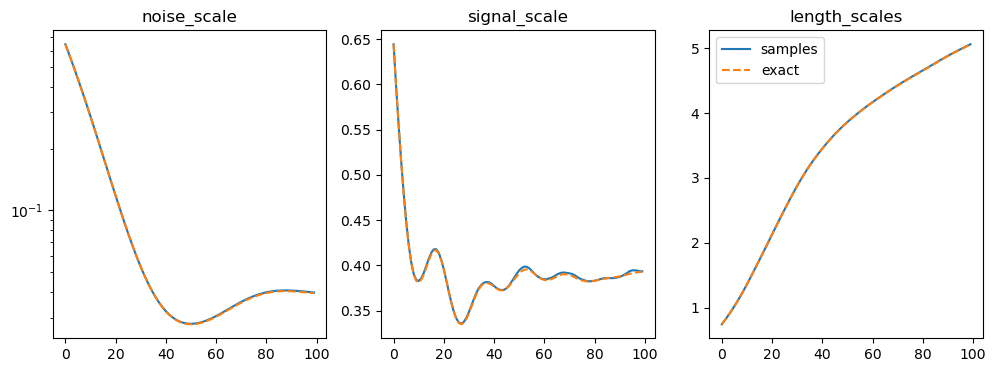

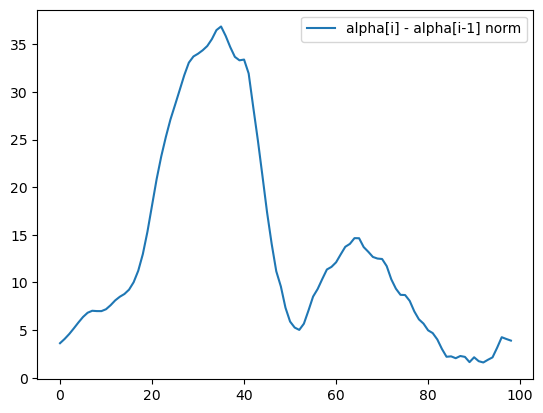

In [9]:
noises = []
signal_scales = []
length_scales = []
for hparam in all_hparams:
    noises.append(hparam.noise_scale)
    signal_scales.append(hparam.kernel_hparams.signal_scale)
    length_scales.append(hparam.kernel_hparams.length_scale)

exact_noises = []
exact_signal_scales = []
exact_length_scales = []
for hparam in exact_hparams_all:
    exact_noises.append(hparam.noise_scale)
    exact_signal_scales.append(hparam.kernel_hparams.signal_scale)
    exact_length_scales.append(hparam.kernel_hparams.length_scale)

exact_length_scales = np.array(exact_length_scales)
length_scales = np.array(length_scales)

# print(exact_length_scales.shape)
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(noises, label='samples')
ax[0].plot(exact_noises, label='exact', linestyle='--')

ax[1].plot(signal_scales, label='samples')
ax[1].plot(exact_signal_scales, label='exact', linestyle='--')

ax[2].plot(np.mean(length_scales, axis=1), label='samples')
ax[2].plot(np.mean(exact_length_scales, axis=1), label='exact', linestyle='--')

ax[0].set_title('noise_scale')
ax[1].set_title('signal_scale')
ax[2].set_title('length_scales')

ax[0].set_yscale('log')
plt.legend()
plt.show()

alpha_map_diffs = []
alpha_map_zero_diffs = []
for i in range(1, len(alpha_maps)):
    alpha_map_diffs.append(np.linalg.norm(alpha_maps[i] - alpha_maps[i-1]))
    alpha_map_zero_diffs.append(np.linalg.norm(alpha_maps[i]))
plt.plot(alpha_map_diffs, label='alpha[i] - alpha[i-1] norm')
# plt.plot(alpha_map_zero_diffs, label='alpha[i] norm')
plt.legend()
plt.show()

100 100


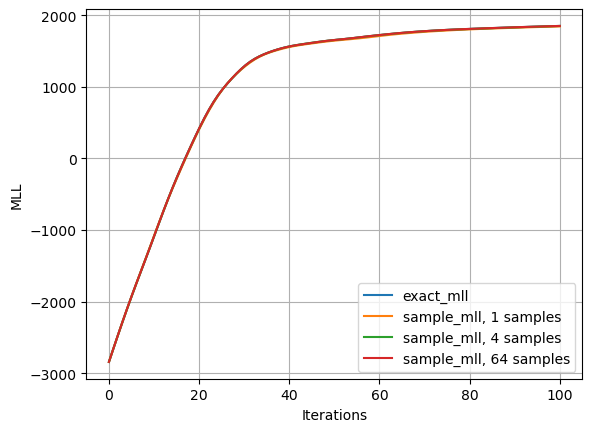

In [11]:


n_samples = [1, 4, 64]
x_vals = np.linspace(0, 100, 100)
print(len(exact_mll), len(sample_mll[64]))

plot_iters = 100
plt.grid()
plt.plot(x_vals[:plot_iters], -np.array(exact_mll)[:plot_iters], label='exact_mll')
for sample in n_samples:
    plt.plot(x_vals[:plot_iters], -np.array(sample_mll[sample])[:plot_iters], label=f'sample_mll, {sample} samples')
plt.xlabel('Iterations')
plt.ylabel('MLL')
plt.legend()
# plt.yscale('log')
# plt.ylim([7e2, 9e2])
plt.show()

### Optimise $\bar{\alpha}$ keeping samples fixed

In [5]:
# Define all the functions we need to optimise MAP and samples (naively for now without vmap)
from chex import Array

def get_alpha_map(train_x, train_y, kernel_fn, hparams, iter_num, init_alpha: Array = None,
                  lr=30., iterations=10000, B=256):
    momentum = 0.9
    polyak = 1e-3

    
    K = kernel.kernel_fn(train_x, train_x, hparams.kernel_hparams)
    H = K + (hparams.noise_scale ** 2) * jnp.eye(N)
    alpha_exact = jsp.linalg.solve(H, train_y, assume_a='pos')

    if init_alpha is None:
        alpha = jnp.zeros((N,))
    else:
        alpha = init_alpha
    alpha_polyak = jnp.zeros((N,))
    optimiser = optax.sgd(learning_rate=lr, momentum=momentum, nesterov=True)
    opt_state = optimiser.init(alpha)
    
    @jax.jit
    def g(params: Array, idx: Array):
        # compute kernel matrix for mini-batch
        # select mini-batch from pre-computed kernel matrix
        K_batch = K[idx]
        grad = jnp.zeros((N,))
        return grad.at[idx].set(K_batch @ params - train_y[idx] + (hparams.noise_scale ** 2) * params[idx]) / B

    @jax.jit
    def get_idx(i: int):
        # implements iterative mini-batches with shuffling after each epoch
        n_steps_per_epoch = N // B
        epoch_id = i // n_steps_per_epoch
        epoch_key = jr.PRNGKey(epoch_id)
        idx = (jnp.arange(B) + (i * B)) % N
        idx = jr.permutation(epoch_key, N)[idx]
        return idx

    @jax.jit
    def update(params: Array, params_polyak: Array, idx: Array, opt_state: optax.OptState):
        grad = g(params, idx)
        updates, opt_state = optimiser.update(grad, opt_state)
        new_params = optax.apply_updates(params, updates)
        new_params_polyak = optax.incremental_update(new_params, params_polyak, step_size=polyak)
        return new_params, new_params_polyak, opt_state, grad

    alpha_diff = []
    grad_norm = []
    alpha_K_diff = []
    
    for i in tqdm(range(iterations)):
        idx = get_idx(i)
        alpha, alpha_polyak, opt_state, grad = update(alpha, alpha_polyak, idx, opt_state)
        alpha_diff.append(jnp.linalg.norm(alpha_polyak - alpha_exact))
        grad_norm.append(jnp.linalg.norm(grad))
        alpha_K_diff.append(jnp.mean((alpha - alpha_exact) @ K @ (alpha - alpha_exact)))
    return alpha_polyak, alpha_diff, grad_norm, alpha_K_diff

In [6]:
import optax
from scalable_gps.linear_model import mll_exact


samples = [64]

for n_samples in samples:

    key = jr.PRNGKey(12345)

    mll_grad_fn = get_mll_grad_fn(
        train_x, train_y, kernel.kernel_fn, kernel.kernel_grad_fn, "samples")

    optimiser = optax.adam(0.2)

    mll_update_fn = get_mll_update_fn(mll_grad_fn, optimiser, 1e-3)

    u_hparams = jax.tree_map(jnp.zeros_like, hparams_exact)
    u_hparams_polyak = jax.tree_map(jnp.zeros_like, hparams_exact)


    opt_state = optimiser.init(u_hparams)
    iterations = 100

    sample_mll[n_samples] = []
    alpha_diffs = []
    grad_norms = []
    alpha_K_diffs = []
    all_hparams = []
    alpha_map = None
    alpha_maps = []
    
    for i in tqdm(range(iterations)):
        hparams = jax.tree_map(jax.nn.softplus, u_hparams)
        
        # hparams = hparams._replace(noise_scale=0.03686391)
        
        # Calculate alpha and alpha_samples
        K = kernel.kernel_fn(train_x, train_x, hparams.kernel_hparams)
        H = K + (hparams.noise_scale ** 2) * jnp.eye(N)
        
        alpha_map, alpha_diff, grad_norm, alpha_K_diff = get_alpha_map(
            train_x, train_y, kernel.kernel_fn, hparams, i, init_alpha=alpha_map,
            lr=30., iterations=50000 if i == 0 else 10000, B=512)
        alpha_maps.append(alpha_map)
        alpha_diffs.extend(alpha_diff)
        grad_norms.extend(grad_norm)
        alpha_K_diffs.extend(alpha_K_diff)
        
        # fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        # ax[0].plot(alpha_diff)
        # ax[1].plot(grad_norm)
        # ax[2].plot(alpha_K_diff)
        # for l in range(3):
        #     ax[l].semilogy()
        # plt.show()
        # alpha_map = jsp.linalg.solve(H, train_y, assume_a='pos')
        
        H_inv = jnp.linalg.inv(H)
        alpha_samples = jr.multivariate_normal(
            key, jnp.zeros(N), H_inv, shape=(n_samples,))
        
        # Pass in alpha_map, alpha_samples
        u_hparams, u_hparams_polyak, opt_state = mll_update_fn(
            u_hparams, u_hparams_polyak, alpha_map, alpha_samples, None, None, opt_state)
        
        hparams = jax.tree_map(jax.nn.softplus, u_hparams)
        # hparams = hparams._replace(noise_scale=0.03686391)
        all_hparams.append(hparams)
        
        sample_mll[n_samples].append(mll_exact(train_x, train_y, kernel.kernel_fn, hparams))
            # print(exact_mll_loss(train_x, train_y, kernel.kernel_fn, hparams))
    # print(exact_mll_loss(train_x, train_y, kernel.kernel_fn, hparams))

alpha_diffs = np.array(alpha_diffs)


100%|██████████| 100/100 [12:36<00:00,  7.57s/it]


In [64]:
reinit_alpha_mll = sample_mll[64]
reinit_alpha_diff = alpha_diffs

No handles with labels found to put in legend.


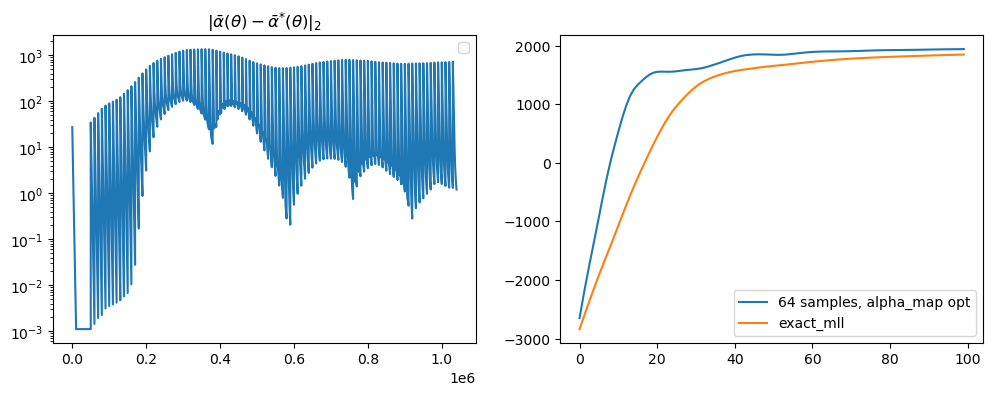

No handles with labels found to put in legend.
No handles with labels found to put in legend.


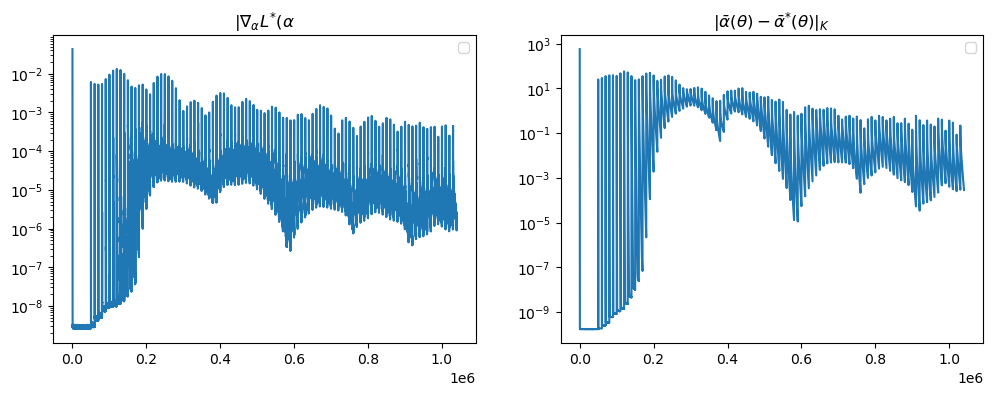

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

alpha_diffs = np.array(alpha_diffs)
# for i in range(10):
#     ax[0].plot(alpha_diffs[i * 50000:(i + 1) * 50000], label=f'iter {i}')
ax[0].plot(alpha_diffs)
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title(r'$\|\bar{\alpha}(\theta) - \bar{\alpha}^{*}(\theta)\|_2$')

ax[1].plot(-1 * np.array(sample_mll[64]), label='64 samples, alpha_map opt')
ax[1].plot(-1 * np.array(exact_mll), label='exact_mll')

plt.legend()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

alpha_K_diffs = np.array(alpha_K_diffs)
grad_norms = np.array(grad_norms)
# for i in range(10):
#     ax[0].plot(alpha_diffs[i * 50000:(i + 1) * 50000], label=f'iter {i}')
ax[0].plot(grad_norms)
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title(r'$\|\nabla_{\alpha} L^{*}(\alpha}) \|_2$')

ax[1].plot(alpha_K_diffs)
ax[1].set_yscale('log')
ax[1].set_title(r'$\|\bar{\alpha}(\theta) - \bar{\alpha}^{*}(\theta)\|_K$')
plt.legend()
plt.show()
# plt.plot(alpha_diffs)

sgd best test RMSE  0.119129956
exact best test RMSE  0.124364


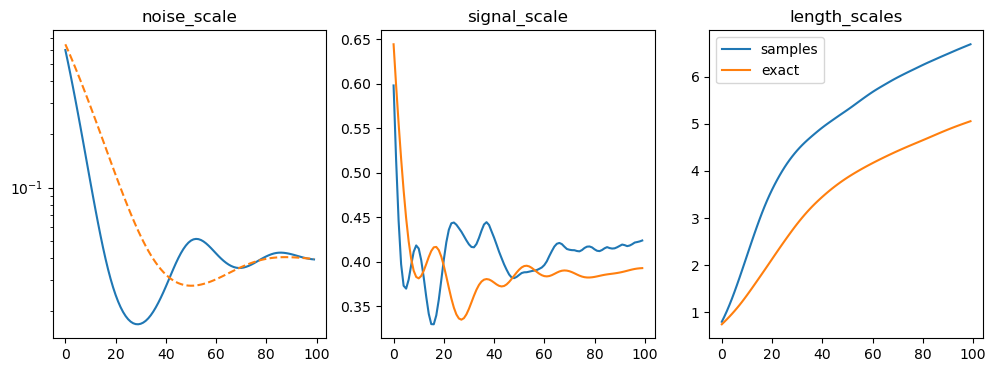

In [9]:
noises = []
signal_scales = []
length_scales = []
for hparam in all_hparams:
    noises.append(hparam.noise_scale)
    signal_scales.append(hparam.kernel_hparams.signal_scale)
    length_scales.append(hparam.kernel_hparams.length_scale)

exact_noises = []
exact_signal_scales = []
exact_length_scales = []
for hparam in exact_hparams_all:
    exact_noises.append(hparam.noise_scale)
    exact_signal_scales.append(hparam.kernel_hparams.signal_scale)
    exact_length_scales.append(hparam.kernel_hparams.length_scale)
    
    
sgd_hparams = all_hparams[-1]
exact_hparams = exact_hparams_all[-1]

K = kernel.kernel_fn(train_x, train_x, sgd_hparams.kernel_hparams)
H = K + (sgd_hparams.noise_scale ** 2) * jnp.identity(N)
alpha_exact = jsp.linalg.solve(H, train_y, assume_a='pos')
y_pred_test_exact = kernel.kernel_fn(test_x, train_x, sgd_hparams.kernel_hparams) @ alpha_exact
test_rmse_exact = jnp.sqrt(jnp.mean((y_pred_test_exact - test_y) ** 2))
print('sgd best test RMSE ', test_rmse_exact)
K = kernel.kernel_fn(train_x, train_x, exact_hparams.kernel_hparams)
H = K + (exact_hparams.noise_scale ** 2) * jnp.identity(N)
alpha_exact = jsp.linalg.solve(H, train_y, assume_a='pos')
y_pred_test_exact = kernel.kernel_fn(test_x, train_x, exact_hparams.kernel_hparams) @ alpha_exact
test_rmse_exact = jnp.sqrt(jnp.mean((y_pred_test_exact - test_y) ** 2))
print('exact best test RMSE ', test_rmse_exact)
exact_length_scales = np.array(exact_length_scales)
length_scales = np.array(length_scales)

# print(exact_length_scales.shape)./
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(noises, label='samples')
ax[0].plot(exact_noises, label='exact', linestyle='--')

ax[1].plot(signal_scales, label='samples')
ax[1].plot(exact_signal_scales, label='exact')

ax[2].plot(np.mean(length_scales, axis=1), label='samples')
ax[2].plot(np.mean(exact_length_scales, axis=1), label='exact')

# print(np.mean(length_scales - exact_length_scales, axis=1))
ax[0].set_title('noise_scale')
ax[1].set_title('signal_scale')
ax[2].set_title('length_scales')

ax[0].set_yscale('log')
plt.legend()
plt.show()

### Optimise both $\bar{\alpha}$ and samples $\alpha_i$

In [6]:
def get_alpha_samples(train_x, train_y, kernel_fn, feature_params_fn, feature_fn, hparams, iter_num, init_alpha: Array = None,
                      lr=30., iterations=10000, B=256):
    key = jax.random.key(123)
    
    prior_noise_key, feature_key = jax.random.split(key)
    momentum = 0.9
    polyak = 1e-3
    n_features = 100
    n_samples = 64

    N, D = train_x.shape
    
    def _draw_f0_and_eps_samples(_key):
        prior_noise_key, feature_key = jax.random.split(_key)
        feature_params = feature_params_fn(feature_key, n_features, D)
        L = feature_fn(train_x, feature_params, hparams.kernel_hparams)
        
        w_sample = jr.normal(key, shape=(n_features,))
        _f0_samples_train = L @ w_sample
        
        _eps_sample = hparams.noise_scale * jr.normal(prior_noise_key, shape=(N,))
        
        return _f0_samples_train, _eps_sample
    
    f0_samples_train, eps_sample = jax.vmap(_draw_f0_and_eps_samples)(jr.split(key, n_samples))
    
    print(f'f0_samples_train shape {f0_samples_train.shape}')
    print(f'eps_sample shape {eps_sample.shape}')
    
    K = kernel.kernel_fn(train_x, train_x, hparams.kernel_hparams)
    H = K + (hparams.noise_scale ** 2) * jnp.eye(N)
    
    # H_inv = jnp.linalg.inv(H)
    # alpha_samples_exact = jr.multivariate_normal(
    #     key, jnp.zeros(N), H_inv, shape=(n_samples,))


    if init_alpha is None:
        alpha = jnp.zeros((n_samples, N))
    else:
        alpha = init_alpha
    alpha_polyak = jnp.zeros((n_samples, N))
    optimiser = optax.sgd(learning_rate=lr, momentum=momentum, nesterov=True)
    opt_state = optimiser.init(alpha)
    
    @jax.jit
    def g(params: Array, idx: Array, err_target: Array, reg_target: Array):
        # compute kernel matrix for mini-batch
        # select mini-batch from pre-computed kernel matrix
        K_batch = K[idx]
        grad = jnp.zeros((N,))
        return grad.at[idx].set(
            K_batch @ params - err_target[idx] + (hparams.noise_scale ** 2) * params[idx] - reg_target[idx]) / B

    @jax.jit
    def get_idx(i: int):
        # implements iterative mini-batches with shuffling after each epoch
        n_steps_per_epoch = N // B
        epoch_id = i // n_steps_per_epoch
        epoch_key = jr.PRNGKey(epoch_id)
        idx = (jnp.arange(B) + (i * B)) % N
        idx = jr.permutation(epoch_key, N)[idx]
        return idx

    @jax.jit
    def update(params: Array, params_polyak: Array, idx: Array, opt_state: optax.OptState,
               err_target: Array, reg_target: Array):
        grad = g(params, idx, err_target, reg_target)
        updates, opt_state = optimiser.update(grad, opt_state)
        new_params = optax.apply_updates(params, updates)
        new_params_polyak = optax.incremental_update(new_params, params_polyak, step_size=polyak)
        return new_params, new_params_polyak, opt_state, grad

    update_fn = jax.vmap(update, in_axes=(0, 0, None, 0, 0, 0))
    
    alpha_diff = []
    grad_norm = []
    alpha_K_diff = []
    
    for i in tqdm(range(iterations)):
        idx = get_idx(i)
        alpha, alpha_polyak, opt_state, grad = update_fn(
            alpha, alpha_polyak, idx, opt_state, f0_samples_train, eps_sample)
        # alpha_diff.append(jnp.linalg.norm(alpha_polyak - alpha_samples_exact))
        grad_norm.append(jnp.linalg.norm(grad))
    return alpha_polyak, None, grad_norm, None

In [24]:
alpha_samples, _, grad_norm, _ = get_alpha_samples(
    train_x, train_y, kernel.kernel_fn, kernel.feature_params_fn, kernel.feature_fn, 
    all_hparams[-1], 0)

f0_samples_train shape (64, 3000)
eps_sample shape (64, 3000)


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:15<00:00, 655.18it/s]


In [7]:
import optax
from scalable_gps.linear_model import mll_exact


samples = [64]
samples_mll = []
for n_samples in samples:

    key = jr.PRNGKey(12345)

    mll_grad_fn = get_mll_grad_fn(
        train_x, train_y, kernel.kernel_fn, kernel.kernel_grad_fn, "samples")

    optimiser = optax.adam(0.2)

    mll_update_fn = get_mll_update_fn(mll_grad_fn, optimiser, 1e-3)

    u_hparams = jax.tree_map(jnp.zeros_like, hparams_exact)
    u_hparams_polyak = jax.tree_map(jnp.zeros_like, hparams_exact)


    opt_state = optimiser.init(u_hparams)
    iterations = 100

    sample_mll[n_samples] = []
    alpha_diffs = []
    grad_norms = []
    sample_grad_norms = []
    alpha_K_diffs = []
    all_hparams_samples = []
    alpha_map = None
    alpha_samples = None
    alpha_maps = []
    
    for i in tqdm(range(iterations)):
        hparams = jax.tree_map(jax.nn.softplus, u_hparams)
        
        # hparams = hparams._replace(noise_scale=0.03686391)
        
        # Calculate alpha and alpha_samples
        K = kernel.kernel_fn(train_x, train_x, hparams.kernel_hparams)
        H = K + (hparams.noise_scale ** 2) * jnp.eye(N)
        
        alpha_map, alpha_diff, grad_norm, alpha_K_diff = get_alpha_map(
            train_x, train_y, kernel.kernel_fn, hparams, i, init_alpha=alpha_map,
            lr=40., iterations=50000 if i == 0 else 10000, B=512)
        
        
        alpha_maps.append(alpha_map)
        alpha_diffs.extend(alpha_diff)
        grad_norms.extend(grad_norm)
        alpha_K_diffs.extend(alpha_K_diff)
        
        # print(f'alpha_samples : ', alpha_samples)
        
        alpha_samples, _, sample_grad_norm, _ = get_alpha_samples(
            train_x, train_y, kernel.kernel_fn, kernel.feature_params_fn, kernel.feature_fn, hparams, i,
            init_alpha=alpha_samples)
        
        print(f'alpha_samples : ', alpha_samples.shape)
        
        sample_grad_norms.extend(sample_grad_norm)
        # Pass in alpha_map, alpha_samples
        u_hparams, u_hparams_polyak, opt_state = mll_update_fn(
            u_hparams, u_hparams_polyak, alpha_map, alpha_samples, None, None, opt_state)
        
        hparams = jax.tree_map(jax.nn.softplus, u_hparams)
        # hparams = hparams._replace(noise_scale=0.03686391)
        all_hparams_samples.append(hparams)
        
        samples_mll.append(mll_exact(train_x, train_y, kernel.kernel_fn, hparams))
            # print(exact_mll_loss(train_x, train_y, kernel.kernel_fn, hparams))
    # print(exact_mll_loss(train_x, train_y, kernel.kernel_fn, hparams))

alpha_diffs = np.array(alpha_diffs)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [01:07<00:00, 744.76it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 385.01it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.75it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 398.59it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.46it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.85it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 438.23it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 399.47it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.38it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 393.35it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.68it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:27<00:00, 368.48it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 432.72it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 381.42it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 439.57it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.60it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 438.87it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 385.04it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.30it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 384.85it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.25it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 390.52it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 434.80it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 398.23it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.98it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 396.38it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.61it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 387.73it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 440.72it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:27<00:00, 366.09it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 440.25it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 388.76it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 426.53it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 387.50it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.54it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 399.39it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 446.21it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 392.89it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.22it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 391.70it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 446.83it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 392.67it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 446.96it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 386.70it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.44it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:28<00:00, 355.43it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 440.98it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 383.97it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.61it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 390.86it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 439.56it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.69it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.98it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 385.72it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.40it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 388.38it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.42it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 390.85it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 439.61it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 393.91it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:24<00:00, 416.48it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 390.66it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.66it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 378.17it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.47it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 393.95it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 446.87it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 395.46it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.22it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 386.55it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.59it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 395.30it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.21it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 398.82it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.62it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 391.60it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.92it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 383.37it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.07it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 394.88it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 417.10it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 386.41it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.38it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 395.75it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.93it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.79it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.65it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.55it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.80it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.19it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.40it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:27<00:00, 370.27it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.79it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 372.28it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.41it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 397.08it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 440.74it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 394.75it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.37it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 385.80it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.50it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 391.68it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.64it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 391.49it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:24<00:00, 406.37it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 390.29it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.23it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 393.86it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.50it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 392.21it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.35it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 388.96it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.71it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 391.80it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.13it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 390.09it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 447.17it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 395.33it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.85it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.25it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 440.34it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 374.31it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.64it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 393.01it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 450.21it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 388.90it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.11it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.54it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.59it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.01it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.79it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 386.15it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 447.09it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:28<00:00, 353.84it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.55it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.36it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.81it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 388.26it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.59it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.43it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.34it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 387.71it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 446.32it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 380.50it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 449.93it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 390.38it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 441.29it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 387.57it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.27it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 395.75it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 439.70it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 396.39it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 447.21it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 395.67it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 433.05it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 383.67it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 440.14it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 371.30it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 444.85it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 379.47it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 433.21it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 386.60it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 438.32it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 393.61it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.00it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 389.25it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 442.99it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 381.72it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 438.06it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 391.26it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 387.27it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 392.50it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 427.48it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 385.58it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.91it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 383.77it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 447.86it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 398.20it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 429.83it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 374.01it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 430.64it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 392.94it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 436.96it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 395.36it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 437.62it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 390.66it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 445.87it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 396.70it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 431.13it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:27<00:00, 365.24it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 433.03it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 378.17it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 434.65it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:26<00:00, 383.35it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 437.12it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 392.79it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:23<00:00, 429.33it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 387.80it/s]


alpha_samples :  (64, 13500)


100%|██████████| 10000/10000 [00:22<00:00, 443.51it/s]


f0_samples_train shape (64, 13500)
eps_sample shape (64, 13500)


100%|██████████| 10000/10000 [00:25<00:00, 392.87it/s]


alpha_samples :  (64, 13500)


100%|██████████| 100/100 [1:23:04<00:00, 49.85s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


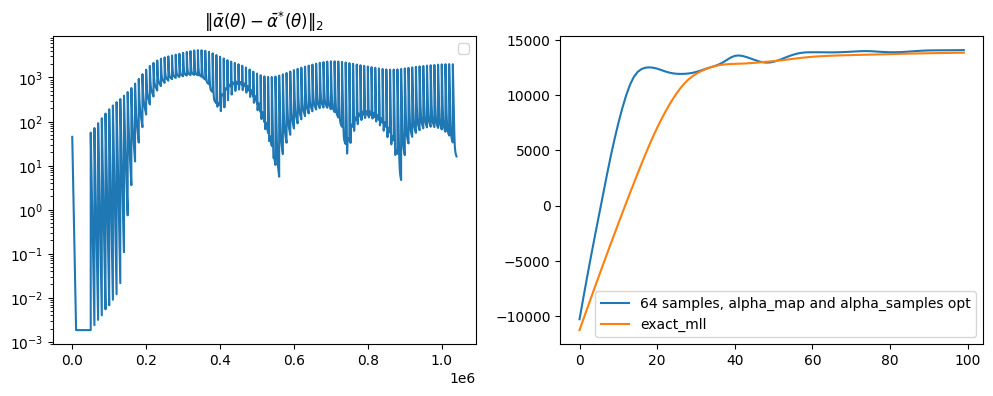

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

alpha_diffs = np.array(alpha_diffs)

np.save('samples_mll.npy', samples_mll)
np.save('exact_mll.npy', exact_mll)
# for i in range(10):
#     ax[0].plot(alpha_diffs[i * 50000:(i + 1) * 50000], label=f'iter {i}')
ax[0].plot(alpha_diffs)
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title(r'$\|\bar{\alpha}(\theta) - \bar{\alpha}^{*}(\theta)\|_2$')

# ax[1].plot(-1 * np.array(sample_mll[64]), label='64 samples, alpha_map opt')
ax[1].plot(-1 * np.array(samples_mll), label='64 samples, alpha_map and alpha_samples opt')
ax[1].plot(-1 * np.array(exact_mll), label='exact_mll')

plt.legend()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

alpha_K_diffs = np.array(alpha_K_diffs)
grad_norms = np.array(grad_norms)
sample_grad_norms = np.array(sample_grad_norms)
# for i in range(10):
#     ax[0].plot(alpha_diffs[i * 50000:(i + 1) * 50000], label=f'iter {i}')
ax[0].plot(grad_norms)
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_title(r'$\|\nabla_{\alpha} L^{*}(\alpha}) \|_2$')

ax[2].plot(grad_norms)
ax[2].set_yscale('log')
ax[2].legend()
ax[2].set_title(r'$\|\nabla_{\alpha} L^{*}(\alpha_i} ) \|_2$')

ax[1].plot(alpha_K_diffs)
ax[1].set_yscale('log')
ax[1].set_title(r'$\|\bar{\alpha}(\theta) - \bar{\alpha}^{*}(\theta)\|_K$')
plt.legend()
plt.show()
# plt.plot(alpha_diffs)

sgd best test RMSE  0.12077166
exact best test RMSE  0.124364


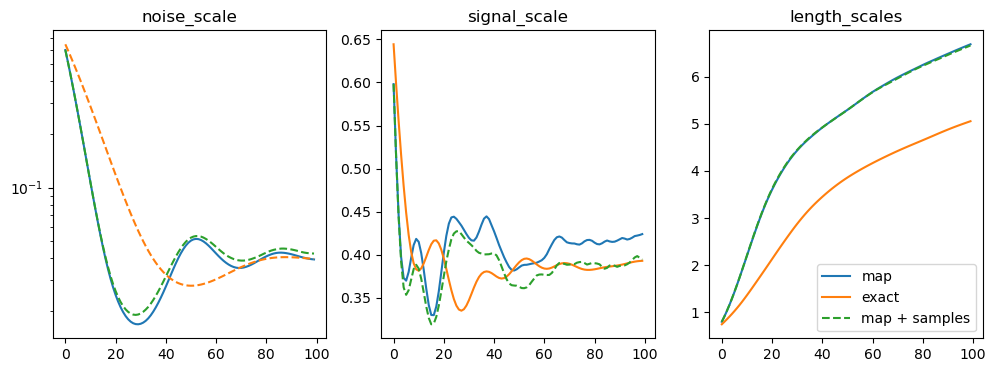

In [ ]:
noises = []
signal_scales = []
length_scales = []
for hparam in all_hparams:
    noises.append(hparam.noise_scale)
    signal_scales.append(hparam.kernel_hparams.signal_scale)
    length_scales.append(hparam.kernel_hparams.length_scale)
    
sample_noises = []
sample_signal_scales = []
sample_length_scales = []
for hparam in all_hparams_samples:
    sample_noises.append(hparam.noise_scale)
    sample_signal_scales.append(hparam.kernel_hparams.signal_scale)
    sample_length_scales.append(hparam.kernel_hparams.length_scale)

exact_noises = []
exact_signal_scales = []
exact_length_scales = []
for hparam in exact_hparams_all:
    exact_noises.append(hparam.noise_scale)
    exact_signal_scales.append(hparam.kernel_hparams.signal_scale)
    exact_length_scales.append(hparam.kernel_hparams.length_scale)
    
    
sgd_hparams = all_hparams_samples[-1]
exact_hparams = exact_hparams_all[-1]

K = kernel.kernel_fn(train_x, train_x, sgd_hparams.kernel_hparams)
H = K + (sgd_hparams.noise_scale ** 2) * jnp.identity(N)
alpha_exact = jsp.linalg.solve(H, train_y, assume_a='pos')
y_pred_test_exact = kernel.kernel_fn(test_x, train_x, sgd_hparams.kernel_hparams) @ alpha_exact
test_rmse_exact = jnp.sqrt(jnp.mean((y_pred_test_exact - test_y) ** 2))
print('sgd best test RMSE ', test_rmse_exact)
K = kernel.kernel_fn(train_x, train_x, exact_hparams.kernel_hparams)
H = K + (exact_hparams.noise_scale ** 2) * jnp.identity(N)
alpha_exact = jsp.linalg.solve(H, train_y, assume_a='pos')
y_pred_test_exact = kernel.kernel_fn(test_x, train_x, exact_hparams.kernel_hparams) @ alpha_exact
test_rmse_exact = jnp.sqrt(jnp.mean((y_pred_test_exact - test_y) ** 2))
print('exact best test RMSE ', test_rmse_exact)
# exact_length_scales = np.array(exact_length_scales)
# length_scales = np.array(length_scales)

# print(exact_length_scales.shape)./
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].plot(noises, label='map')
ax[0].plot(exact_noises, label='exact', linestyle='--')
ax[0].plot(sample_noises, label='map + samples', linestyle='--')

ax[1].plot(signal_scales, label='map')
ax[1].plot(exact_signal_scales, label='exact')
ax[1].plot(sample_signal_scales, label='map + samples', linestyle='--')

ax[2].plot(np.mean(length_scales, axis=1), label='map')
ax[2].plot(np.mean(exact_length_scales, axis=1), label='exact')
ax[2].plot(np.mean(sample_length_scales, axis=1), label='map + samples', linestyle='--')

# print(np.mean(length_scales - exact_length_scales, axis=1))
ax[0].set_title('noise_scale')
ax[1].set_title('signal_scale')
ax[2].set_title('length_scales')

ax[0].set_yscale('log')
plt.legend()
plt.show()